In [420]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import KFold, train_test_split

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score


In [421]:
original_df = pd.read_csv('./data/atp_matches_2017.csv', index_col=False, skip_blank_lines=True)
original_df.drop(columns=['tourney_id', 'surface', 'draw_size', 'tourney_level', 'winner_id', 'winner_entry', 'winner_hand', 'winner_ht', 'winner_ioc', 
                            'winner_rank_points', 'loser_id', 'loser_entry', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_rank_points', 'score'], inplace=True)
original_df.head()


/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/2527174068.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  original_df = pd.read_csv('./data/atp_matches_2017.csv', index_col=False, skip_blank_lines=True)


,tourney_name,tourney_date,match_num,winner_seed,winner_name,winner_age,winner_rank,loser_seed,loser_name,loser_age,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,Brisbane,20170102,300,7.0,Grigor Dimitrov,25.634497,17.0,3.0,Kei Nishikori,27.011636,...,7.0,4.0,0.0,69.0,49.0,36.0,9.0,12.0,2.0,5.0
1,Brisbane,20170102,299,7.0,Grigor Dimitrov,25.634497,17.0,1.0,Milos Raonic,26.017796,...,0.0,4.0,3.0,61.0,28.0,24.0,16.0,10.0,2.0,4.0
2,Brisbane,20170102,298,3.0,Kei Nishikori,27.011636,5.0,2.0,Stanislas Wawrinka,31.767283,...,5.0,9.0,2.0,61.0,37.0,27.0,10.0,10.0,0.0,2.0
3,Brisbane,20170102,297,1.0,Milos Raonic,26.017796,3.0,5.0,Rafael Nadal,30.584531,...,7.0,4.0,0.0,84.0,61.0,39.0,14.0,14.0,2.0,4.0
4,Brisbane,20170102,296,7.0,Grigor Dimitrov,25.634497,17.0,4.0,Dominic Thiem,23.331964,...,14.0,6.0,5.0,82.0,37.0,29.0,24.0,14.0,4.0,7.0


In [422]:
original_df.shape

(388, 32)

In [423]:
tennis_df = original_df.drop(columns=['winner_name', 'loser_name', 'winner_seed', 'loser_seed', 'tourney_name', 'round', 'minutes']) #don't care about these or contain many NaN values
tennis_df.dropna(inplace=True)
tennis_df.rename(columns={'winner_age': 'w_age', 'loser_age': 'l_age', 'winner_rank': 'w_rank', 'loser_rank': 'l_rank', 'tourney_date': 'date'}, inplace=True)
tennis_df['response'] = 1
tennis_df.head()

,date,match_num,w_age,w_rank,l_age,l_rank,best_of,w_ace,w_df,w_svpt,...,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,response
0,20170102,300,25.634497,17.0,27.011636,5.0,3,7.0,2.0,77.0,...,4.0,0.0,69.0,49.0,36.0,9.0,12.0,2.0,5.0,1
1,20170102,299,25.634497,17.0,26.017796,3.0,3,4.0,1.0,58.0,...,4.0,3.0,61.0,28.0,24.0,16.0,10.0,2.0,4.0,1
2,20170102,298,27.011636,5.0,31.767283,4.0,3,1.0,1.0,77.0,...,9.0,2.0,61.0,37.0,27.0,10.0,10.0,0.0,2.0,1
3,20170102,297,26.017796,3.0,30.584531,9.0,3,23.0,3.0,97.0,...,4.0,0.0,84.0,61.0,39.0,14.0,14.0,2.0,4.0,1
4,20170102,296,25.634497,17.0,23.331964,8.0,3,3.0,3.0,94.0,...,6.0,5.0,82.0,37.0,29.0,24.0,14.0,4.0,7.0,1


In [424]:
#randomly swap statistics for winner (player w) and loser (player l) to create binary response of 0 and 1, keeping player w as the refernce point. (1 if player w wins , 0 if loses)
#to avoid data leakage
swap = np.random.rand(len(tennis_df)) > 0.5
columns_to_swap = ['age', 'rank', 'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']

for col in columns_to_swap:
    tennis_df.loc[swap, [f'w_{col}', f'l_{col}']] = tennis_df.loc[swap, [f'l_{col}', f'w_{col}']].values

tennis_df.loc[swap, 'response'] = 0

In [425]:
tennis_df.head()

,date,match_num,w_age,w_rank,l_age,l_rank,best_of,w_ace,w_df,w_svpt,...,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,response
0,20170102,300,25.634497,17.0,27.011636,5.0,3,7.0,2.0,77.0,...,4.0,0.0,69.0,49.0,36.0,9.0,12.0,2.0,5.0,1
1,20170102,299,25.634497,17.0,26.017796,3.0,3,4.0,1.0,58.0,...,4.0,3.0,61.0,28.0,24.0,16.0,10.0,2.0,4.0,1
2,20170102,298,27.011636,5.0,31.767283,4.0,3,1.0,1.0,77.0,...,9.0,2.0,61.0,37.0,27.0,10.0,10.0,0.0,2.0,1
3,20170102,297,30.584531,9.0,26.017796,3.0,3,4.0,0.0,84.0,...,23.0,3.0,97.0,62.0,50.0,16.0,15.0,6.0,7.0,0
4,20170102,296,25.634497,17.0,23.331964,8.0,3,3.0,3.0,94.0,...,6.0,5.0,82.0,37.0,29.0,24.0,14.0,4.0,7.0,1


In [426]:
tennis_df.response.value_counts() 

response
0    174
1    171
Name: count, dtype: int64

In [427]:
#Create a dataframe of the difference of corresponding statistic between player w and player l
predictors = ['age', 'rank','ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon',
               'SvGms', 'bpSaved', 'bpFaced']
diff_df = pd.DataFrame()
for pred in predictors:
    diff_df[pred] = tennis_df['w_'+pred] - tennis_df['l_'+pred]
diff_df['date'] = tennis_df['date']
diff_df.head()

,age,rank,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,date
0,-1.377139,12.0,3.0,2.0,8.0,3.0,5.0,3.0,1.0,3.0,2.0,20170102
1,-0.383299,14.0,0.0,-2.0,-3.0,8.0,3.0,2.0,0.0,-2.0,-4.0,20170102
2,-4.755647,1.0,-8.0,-1.0,16.0,19.0,10.0,4.0,1.0,4.0,3.0,20170102
3,4.566735,6.0,-19.0,-3.0,-13.0,-1.0,-11.0,-2.0,-1.0,-4.0,-3.0,20170102
4,2.302533,9.0,-3.0,-2.0,12.0,15.0,13.0,-1.0,0.0,9.0,7.0,20170102


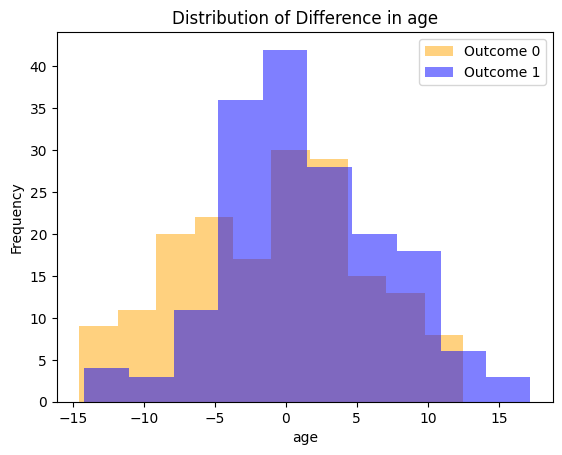

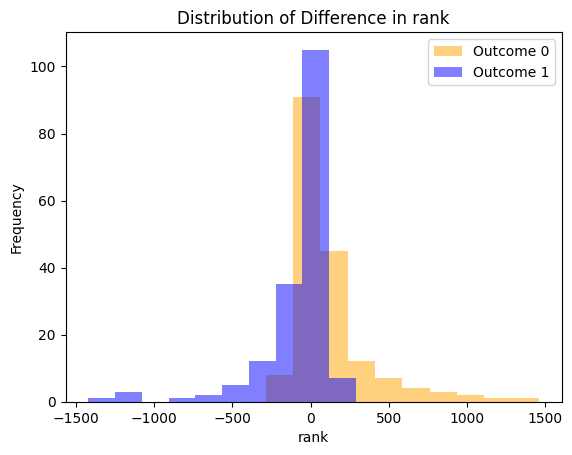

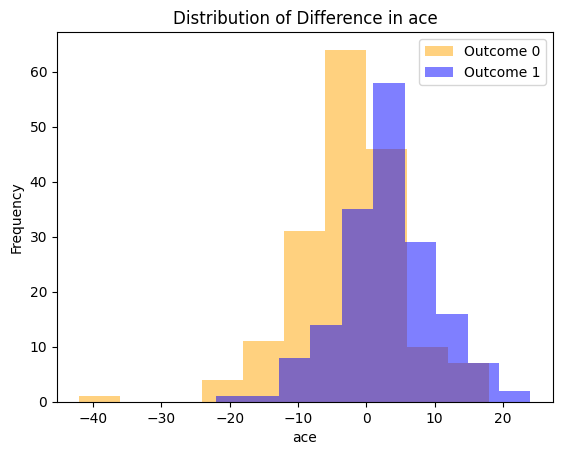

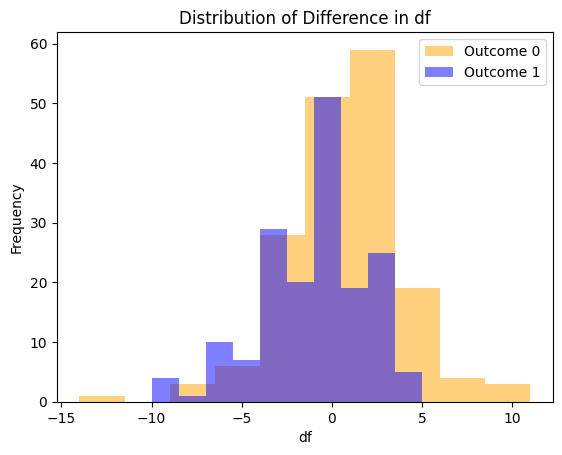

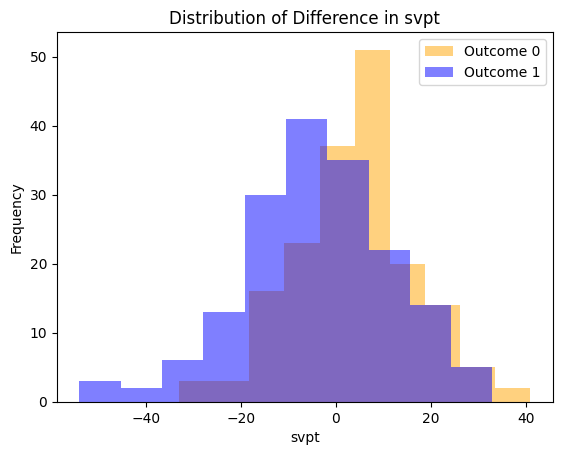

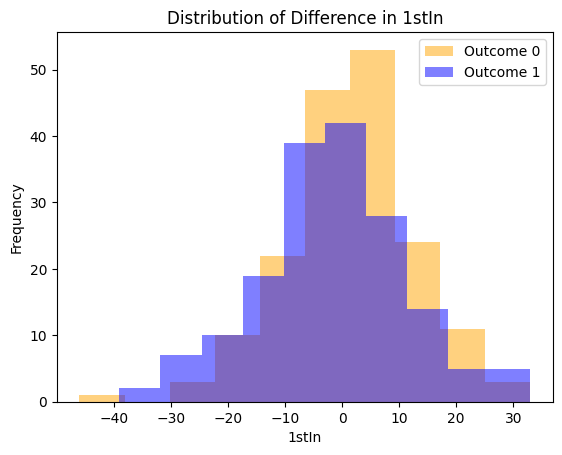

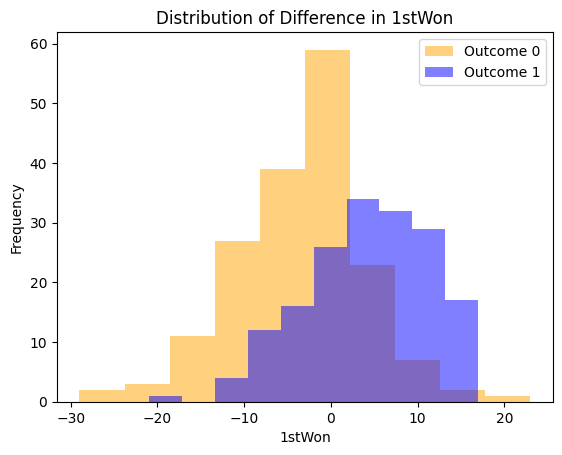

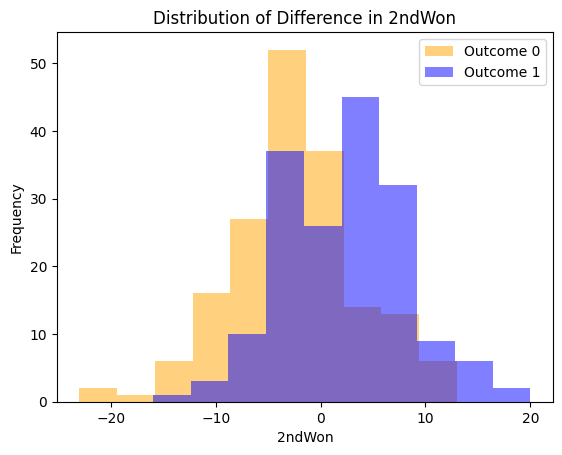

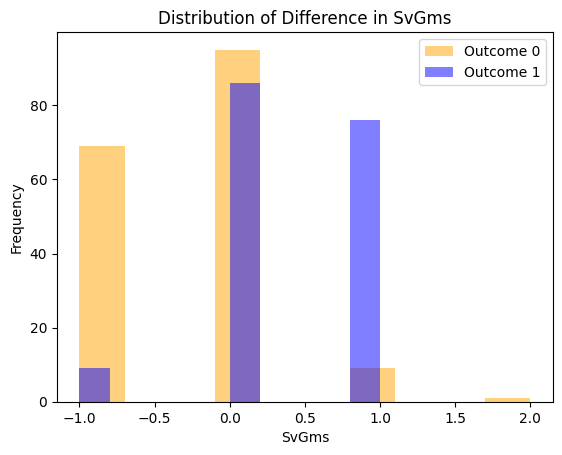

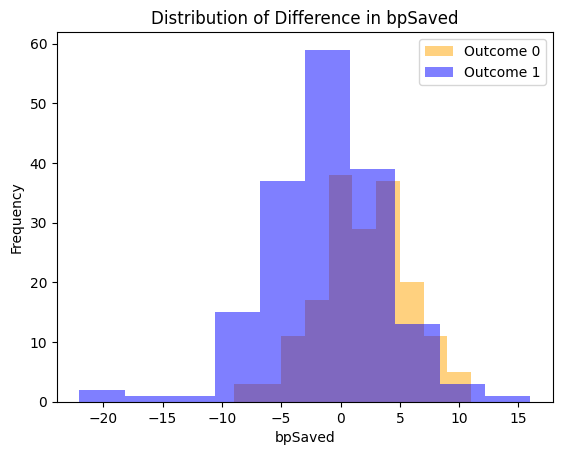

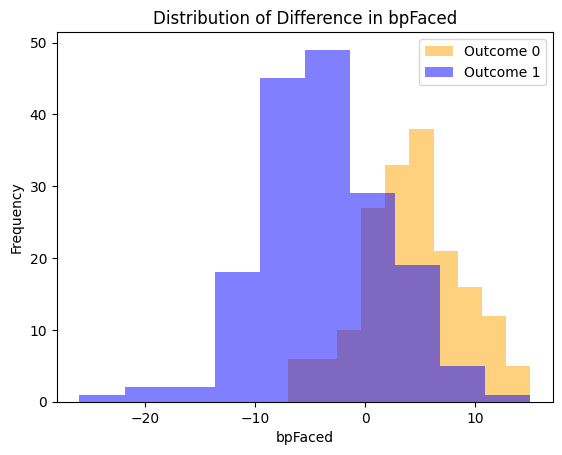

In [428]:
diff_df['response'] = tennis_df['response']

colors = {0: "orange", 1: "blue"}
for pred in predictors:
    for res, color in colors.items():
        subset = diff_df[diff_df["response"] == res]  
        plt.hist(subset[pred], color=color, label=f"Outcome {res}", alpha=0.5)

    # Labels and title
    plt.xlabel(pred)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Difference in {pred}")
    plt.legend()
    plt.show()

Based on these graphs, my ranking of the best predictors are: 
- Best: 1stWon (points won on first serve), bpFaced (break point faced)
- 2nd Best: svpt (serve point), 2ndWon (points won on second serve)
- 3rd Best: Ace, svGms (serve games)

My ranking is based on the overlap (lack thereof actually) of the distribution between winner and loser across 0. (0 indicates both players had the same statistic so their difference is 0)

In [429]:
diff_df.columns

Index(['age', 'rank', 'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon',
       'SvGms', 'bpSaved', 'bpFaced', 'date', 'response'],
      dtype='object')

In [430]:
#Check collinearity between these selected columns
diff_df[['ace', 'svpt', '1stWon', '2ndWon','SvGms', 'bpFaced', 'response']].corr()

,ace,svpt,1stWon,2ndWon,SvGms,bpFaced,response
ace,1.000000,-0.133408,0.238071,0.078392,0.235785,-0.224462,0.363998
svpt,-0.133408,1.000000,0.264392,0.175082,-0.102083,0.716906,-0.278897
1stWon,0.238071,0.264392,1.000000,-0.207215,0.327853,-0.145151,0.476869
2ndWon,0.078392,0.175082,-0.207215,1.000000,0.270989,-0.134290,0.365473
SvGms,0.235785,-0.102083,0.327853,0.270989,1.000000,-0.371387,0.521478
bpFaced,-0.224462,0.716906,-0.145151,-0.134290,-0.371387,1.000000,-0.614641
response,0.363998,-0.278897,0.476869,0.365473,0.521478,-0.614641,1.000000


In [431]:
diff_df.shape

(345, 13)

In [432]:
scalar = StandardScaler()
preds = ['ace', 'svpt', '1stWon', '2ndWon','SvGms', 'bpFaced']
for pred in preds:
    diff_df[pred+'_scaled'] = scalar.fit_transform(diff_df[[pred]])
diff_df.head()

,age,rank,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,date,response,ace_scaled,svpt_scaled,1stWon_scaled,2ndWon_scaled,SvGms_scaled,bpFaced_scaled
0,-1.377139,12.0,3.0,2.0,8.0,3.0,5.0,3.0,1.0,3.0,2.0,20170102,1,0.382524,0.544936,0.584636,0.477750,1.400803,0.279543
1,-0.383299,14.0,0.0,-2.0,-3.0,8.0,3.0,2.0,0.0,-2.0,-4.0,20170102,1,0.007607,-0.205166,0.345230,0.324852,-0.037522,-0.628863
2,-4.755647,1.0,-8.0,-1.0,16.0,19.0,10.0,4.0,1.0,4.0,3.0,20170102,1,-0.992173,1.090466,1.183152,0.630648,1.400803,0.430944
3,4.566735,6.0,-19.0,-3.0,-13.0,-1.0,-11.0,-2.0,-1.0,-4.0,-3.0,20170102,0,-2.366870,-0.887078,-1.330612,-0.286739,-1.475846,-0.477462
4,2.302533,9.0,-3.0,-2.0,12.0,15.0,13.0,-1.0,0.0,9.0,7.0,20170102,1,-0.367310,0.817701,1.542261,-0.133841,-0.037522,1.036549


Only bpFaced and svpt are kind of collinear, all other variables are not collinear. Since bpFaced is a better predictor of response (from plot and correlation matrix), I will use bpFaced and not svpt

In [433]:
diff_df.date.value_counts()

date
20170116    126
20170203     86
20170102     85
20170109     48
Name: count, dtype: int64

I'm going to split up 126 entries from 2017-01-16 into 2/3 vs 1/3 so that the training set includes data from 2017-01-02, 2017-01-09, and 2/3 of 2017-01-16, and the test data will include 1/3 of 2017-01-16 and 2017-02-03 data. The test data makes up roughly 37% of the whole data set, which is a good proportion.

In [ ]:
temp = diff_df[diff_df['date'] == 20170116]
train_temp = temp.iloc[0:84]
test_temp = temp.iloc[84:126]

train = diff_df[(diff_df['date'] == 20170102) | (diff_df['date'] == 20170109)]
train = pd.concat([train, train_temp])
X_train = train[['ace_scaled', '1stWon_scaled', '2ndWon_scaled','SvGms_scaled', 'bpFaced_scaled']]
y_train = train['response']

test = diff_df[(diff_df['date'] == 20170203)]
test = pd.concat([test_temp, test])
X_test = test[['ace_scaled', '1stWon_scaled', '2ndWon_scaled','SvGms_scaled', 'bpFaced_scaled']]
y_test = test['response']

In [527]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV #will regularize by default (l2 penalty)

logreg1 = LogisticRegressionCV(Cs=10, cv=5, scoring='accuracy') #kfold test with 5 folds on the training set. Tests 10 different C values for each round of kfold
logreg1.fit(X_train, y_train)
best_C = logreg1.C_[0]
print("Optimal C:", best_C)

Optimal C: 0.3593813663804626


In [528]:
from sklearn.metrics import classification_report

logreg1 = LogisticRegression(C=0.3593813663804626)
logreg1.fit(X_train, y_train)
l1_preds = logreg1.predict(X_test)
print(classification_report(y_test,l1_preds))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        65
           1       0.95      0.97      0.96        63

    accuracy                           0.96       128
   macro avg       0.96      0.96      0.96       128
weighted avg       0.96      0.96      0.96       128



In [529]:
coefs = logreg1.coef_
intercept = logreg1.intercept_
print(f"Intercept: {intercept} \nCoefs: {coefs}")

Intercept: [0.00104824] 
Coefs: [[ 0.58375312  1.60416457  1.41745912  0.35756093 -1.737993  ]]


log(p/(1-p)) = 0.00104824 + 0.58375312(Ace_scaled) + 1.60416457(1stWon_scaled) + 1.41745912(2ndWon_scaled) + 0.35756093(SvGms_scaled) - 1.737993(bpFaced_scaled)

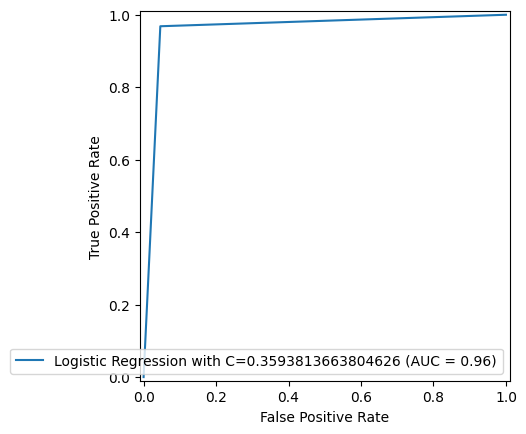

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, l1_preds, drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression with C=0.3593813663804626')
display.plot();

This is very good model to predict the outcome of a match (win or lose). 

Let's try different model with different predictors

Let's see what the correlation matrix looks like for columns I haven't used as predictors in the model above.

In [441]:
diff_df[['age', 'rank', 'df', 'svpt', '1stIn','bpSaved', 'response']].corr()

,age,rank,df,svpt,1stIn,bpSaved,response
age,1.000000,-0.259032,-0.047152,-0.094359,-0.042463,-0.044976,0.182192
rank,-0.259032,1.000000,0.071807,0.223368,0.170526,0.220373,-0.380614
df,-0.047152,0.071807,1.000000,0.288681,-0.059297,0.247622,-0.260946
svpt,-0.094359,0.223368,0.288681,1.000000,0.667551,0.776535,-0.278897
1stIn,-0.042463,0.170526,-0.059297,0.667551,1.000000,0.529841,-0.151588
bpSaved,-0.044976,0.220373,0.247622,0.776535,0.529841,1.000000,-0.306495
response,0.182192,-0.380614,-0.260946,-0.278897,-0.151588,-0.306495,1.000000


Notice rank actually has the strogest correlation with response. But 2ndWon has pretty high odds. Let's try a model substituting rank for ace, and another one substituting rank for ace and 2ndWon, and compare these models using k-fold.

In [442]:
def scale_preds(df, preds):
    '''
    scales numiercal predictors
    '''
    scalar = StandardScaler()
    df[preds] = scalar.fit_transform(df[preds])
    return df

In [534]:
def optimal_threshold(X_train, y_train, best_C):
    '''
    computes optimal threshold (cutoff) for probability to achieve best classification
    on the training set.

    returns a tuple (mean_threshold, median_threshold)
    '''
    kf = KFold(n_splits=5, shuffle=True, random_state=112) 
    thresholds = []  
    for train_idx, val_idx in kf.split(X_train):  
        X_train_sub, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_sub, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = LogisticRegression(C=best_C)
        model.fit(X_train_sub, y_train_sub)
        
        val_probs = model.predict_proba(X_val)[:, 1]
        
        fpr, tpr, threshold_values = metrics.roc_curve(y_val, val_probs)
        
        optimal_idx = np.argmax(tpr - fpr)
        thresholds.append(threshold_values[optimal_idx])
    
    mean_threshold = np.mean(thresholds)
    median_threshold = np.median(thresholds)
        
    return (mean_threshold, median_threshold)


def compute_accuracy(diff_df, preds):
    '''  
    Returns accuracy score of model.
    '''  
    df = diff_df[preds]
    scaled_df = scale_preds(df, preds)
    scaled_df[['date', 'response']] = diff_df[['date', 'response']]
    
    temp = scaled_df.loc[scaled_df['date'] == 20170116]
    train_temp = temp.iloc[0:84]
    test_temp = temp.iloc[84:126]

    train = scaled_df.loc[(scaled_df['date'] == 20170102) | (scaled_df['date'] == 20170109)]
    train = pd.concat([train, train_temp])
    X_train = train[preds]
    y_train = train['response']

    test = scaled_df.loc[(scaled_df['date'] == 20170203)]
    test = pd.concat([test_temp, test])
    X_test = test[preds]
    y_test = test['response']

    logreg = LogisticRegressionCV(Cs=10, cv=5, scoring='accuracy') 
    logreg.fit(X_train, y_train)
    best_C = logreg.C_[0]

    mean_threshold, median_threshold = optimal_threshold(X_train, y_train, best_C)

    #Now that I have best C and optimal thresholds for classification, can test on test data
    logreg1 = LogisticRegression(C=best_C)
    logreg1.fit(X_train, y_train)
    logreg1_proba = logreg1.predict_proba(X_test)[:, 1] 
    median_pred_optimal = (logreg1_proba >= median_threshold).astype(int)
    mean_pred_optimal = (logreg1_proba >= mean_threshold).astype(int)
    
    median_best_accuracy = accuracy_score(y_test, median_pred_optimal)
    mean_best_accuracy = accuracy_score(y_test, mean_pred_optimal)

    return (f'Mean Accuracy:{mean_best_accuracy:.3f}, mean threshold: {mean_threshold:.3f} ---- '
            f'Median Accuracy:{median_best_accuracy:.3f}, median threshold: {median_threshold:.3f}')

In [538]:
#No Ace, with Rank
results = []
predictors = [['1stWon', '2ndWon','SvGms', 'bpFaced'], ['rank', '1stWon', '2ndWon','SvGms', 'bpFaced'], ['rank', '1stWon','SvGms', 'bpFaced'], ['ace', '1stWon', '2ndWon','SvGms', 'bpFaced']]
for num, preds in enumerate(predictors):
    print(f'predictors{num+1}: {compute_accuracy(diff_df, preds)}')

predictors1: Mean Accuracy:0.953, mean threshold: 0.453 ---- Median Accuracy:0.953, median threshold: 0.510
predictors2: Mean Accuracy:0.961, mean threshold: 0.503 ---- Median Accuracy:0.961, median threshold: 0.516
predictors3: Mean Accuracy:0.922, mean threshold: 0.423 ---- Median Accuracy:0.922, median threshold: 0.461
predictors4: Mean Accuracy:0.945, mean threshold: 0.575 ---- Median Accuracy:0.945, median threshold: 0.577


/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/1537862050.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[preds] = scalar.fit_transform(df[preds])
/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/3044904813.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df[['date', 'response']] = diff_df[['date', 'response']]
/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/3044904813.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

The best accuracy was with predictors: ['rank', '1stWon', '2ndWon','SvGms', 'bpFaced'], with scores: 
Mean Accuracy:0.953125, mean threshold: 0.453 ---- Median Accuracy:0.953125, median threshold: 0.510

0.3593813663804626


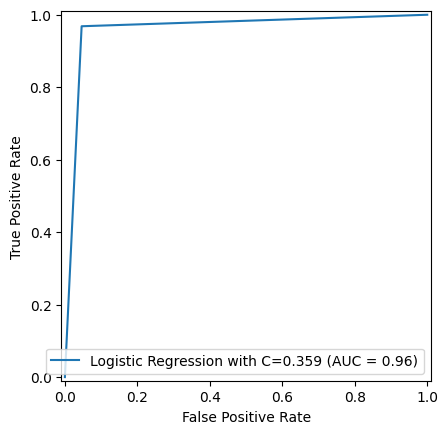

In [546]:
df1 = scale_preds(diff_df, ['rank', '1stWon', '2ndWon','SvGms', 'bpFaced'])
temp = df1[df1['date'] == 20170116]
train_temp = temp.iloc[0:84]
test_temp = temp.iloc[84:126]

train = df1[(diff_df['date'] == 20170102) | (diff_df['date'] == 20170109)]
train = pd.concat([train, train_temp])
X_train_best = train[['rank', '1stWon', '2ndWon','SvGms', 'bpFaced']]
y_train_best = train['response']

test = df1[(df1['date'] == 20170203)]
test = pd.concat([test_temp, test])
X_test_best = test[['rank', '1stWon', '2ndWon','SvGms', 'bpFaced']]
y_test_best = test['response']

model = LogisticRegressionCV(Cs=10, cv=5, scoring='accuracy')
model.fit(X_train_best, y_train_best)
best_C = model.C_[0]
print(best_C)
best_model = LogisticRegression(C=best_C)
best_model.fit(X_train_best, y_train_best)
l1_preds = best_model.predict(X_test_best)
fpr, tpr, thresholds = metrics.roc_curve(y_test_best, l1_preds, drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression with C=0.359')
display.plot();

log(p/(1-p)) = -0.014 + -0.517(rank_scaled) + 1.664(1stWon_scaled) + 1.413(2ndWon_scaled) + 0.375(SvGms_scaled) - 1.776(bpFaced_scaled)

Now let's see if we can do better by using kNN.

In [471]:
# the Euclidean distance
def distance(pt1, pt2):   
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

def row_wise_distance(row, my_point):
    '''Computes the distance between the given my_point and a single df row'''
    return distance(my_point, np.array(row))

def closest(X_train, Y_train, point, k):
    """Outputs a df containing the k closest rows in the training data to array 'point' """
    X_train = X_train.assign(Distance_to_point = X_train.apply(row_wise_distance, args=(point,), axis=1))
    X_train = X_train.sort_values('Distance_to_point') 
    X_train['class'] = Y_train
    topk = X_train.head(k)
    return topk

def majority(topkclasses):
    """1 if the majority of the "mpg" column is 1's, and 0 otherwise."""
    ones = topkclasses[topkclasses['class']==1].shape[0]
    zeros = topkclasses[topkclasses['class']==0].shape[0]
    if ones > zeros:
        return 1
    elif ones < zeros:
        return 0
    else:
        random = np.random.randint(len(topkclasses))
        return topkclasses.iloc[random]['class']


def classify(X_train,Y_train, X_test, k):
    """Classify data in X_test using k-nearest neighbor classification with the given training data.
    Output is a DataFrame with X_test appended by a column of Class prediction"""
    n=X_test.shape[0] 
    
    pred_class = np.array([])
    for i in np.arange(n):
        topkclasses = closest(X_train,Y_train, X_test.iloc[i], k)
        pred_class = np.append(pred_class,majority(topkclasses))
    
    report_df=X_test.copy()
    report_df['Predicted_Class']=pred_class
    
    return report_df

In [446]:
temp = diff_df[diff_df['date'] == 20170116]
train_temp = temp.iloc[0:84]
test_temp = temp.iloc[84:126]

train = diff_df[(diff_df['date'] == 20170102) | (diff_df['date'] == 20170109)]
train = pd.concat([train, train_temp])
X_train_knn = train[['ace_scaled', '1stWon_scaled', '2ndWon_scaled','SvGms_scaled', 'bpFaced_scaled']]
y_train_knn = train['response']

test = diff_df[(diff_df['date'] == 20170203)]
test = pd.concat([test_temp, test])
X_test_knn = test[['ace_scaled', '1stWon_scaled', '2ndWon_scaled','SvGms_scaled', 'bpFaced_scaled']]
y_test_knn = test['response']

In [447]:
kf = KFold(n_splits=5)
accuracies = []

for k in np.arange(1,10):
    temp = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_knn, y_train_knn)):
        k_preds = classify(X_train_knn.iloc[train_idx], y_train_knn.iloc[train_idx], X_train_knn.iloc[val_idx], k)['Predicted_Class'].apply(int)   
        acc = sum(y_train_knn.iloc[val_idx] == k_preds)/len(y_train_knn.iloc[val_idx])
        temp.append(acc)
    accuracies.append(np.mean(temp))

accuracies

[np.float64(0.9077167019027483),
 np.float64(0.8890063424947148),
 np.float64(0.9029598308668076),
 np.float64(0.8892177589852007),
 np.float64(0.8986257928118393),
 np.float64(0.8937632135306555),
 np.float64(0.8846723044397462),
 np.float64(0.907505285412262),
 np.float64(0.9077167019027483)]

In [451]:
diff_df.head()

,age,rank,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,date,response,ace_scaled,svpt_scaled,1stWon_scaled,2ndWon_scaled,SvGms_scaled,bpFaced_scaled
0,-1.377139,12.0,3.0,2.0,8.0,3.0,5.0,3.0,1.0,3.0,2.0,20170102,1,0.382524,0.544936,0.584636,0.477750,1.400803,0.279543
1,-0.383299,14.0,0.0,-2.0,-3.0,8.0,3.0,2.0,0.0,-2.0,-4.0,20170102,1,0.007607,-0.205166,0.345230,0.324852,-0.037522,-0.628863
2,-4.755647,1.0,-8.0,-1.0,16.0,19.0,10.0,4.0,1.0,4.0,3.0,20170102,1,-0.992173,1.090466,1.183152,0.630648,1.400803,0.430944
3,4.566735,6.0,-19.0,-3.0,-13.0,-1.0,-11.0,-2.0,-1.0,-4.0,-3.0,20170102,0,-2.366870,-0.887078,-1.330612,-0.286739,-1.475846,-0.477462
4,2.302533,9.0,-3.0,-2.0,12.0,15.0,13.0,-1.0,0.0,9.0,7.0,20170102,1,-0.367310,0.817701,1.542261,-0.133841,-0.037522,1.036549


In [496]:
#using minmax scaling
def minmax_scaling(x):
    "Convert any array of numbers"
    return (x - np.min(x))/(np.max(x)-np.min(x)) 

def split_data(diff_df, preds):
    temp = diff_df[diff_df['date'] == 20170116]
    train_temp = temp.iloc[0:84]
    test_temp = temp.iloc[84:126]

    train = diff_df[(diff_df['date'] == 20170102) | (diff_df['date'] == 20170109)]
    train = pd.concat([train, train_temp])
    X_train_knn = train[preds]
    y_train_knn = train['response']

    test = diff_df[(diff_df['date'] == 20170203)]
    test = pd.concat([test_temp, test])
    X_test_knn = test[preds]
    y_test_knn = test['response']
    return X_train_knn, X_test, y_train_knn, y_test_knn

def knn_accuracies(df, preds, scale_type):
    '''  
    calculate knn accuracies for given predictors using minmax scaling
    for k=1 through 10
    '''
    scaled_df = df[preds]
    if scale_type == 'minmax':
        for pred in preds:
            scaled_df[pred] = minmax_scaling(scaled_df[pred])
    else:
        scaled_df = scale_preds(df, preds)
        
    scaled_df[['date', 'response']] = df[['date', 'response']]
    X_train_knn, X_test, y_train_knn, y_test_knn = split_data(scaled_df, preds)
    kf = KFold(n_splits=3)
    accuracies = []

    for k in np.arange(1,15):
        temp = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_knn, y_train_knn)):
            k_preds = classify(X_train_knn.iloc[train_idx], y_train_knn.iloc[train_idx], X_train_knn.iloc[val_idx], k)['Predicted_Class'].apply(int)   
            acc = sum(y_train_knn.iloc[val_idx] == k_preds)/len(y_train_knn.iloc[val_idx])
            temp.append(acc)
        accuracies.append(np.mean(temp))

    return accuracies

In [490]:
minmax_scaled_acc = knn_accuracies(diff_df, ['ace', '1stWon', '2ndWon','SvGms', 'bpFaced'], 'minmax')
std_scaled_acc = knn_accuracies(diff_df, ['ace', '1stWon', '2ndWon','SvGms', 'bpFaced'], ' ')
print(f'minmax scaled: \n{minmax_scaled_acc}\nstandard scaled:\n{std_scaled_acc}')

/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/3918339508.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df[pred] = minmax_scaling(scaled_df[pred])
/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/3918339508.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df[['date', 'response']] = df[['date', 'response']]
/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/3918339508.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of

minmax scaled: 
[np.float64(0.8846397767630645), np.float64(0.8477929984779299), np.float64(0.8985920852359208), np.float64(0.8802004058853375), np.float64(0.8848934550989345), np.float64(0.866374936580416), np.float64(0.8847666159309995), np.float64(0.8846397767630645), np.float64(0.884703196347032), np.float64(0.8708777270421106), np.float64(0.8755073566717403), np.float64(0.8801369863013698), np.float64(0.8755073566717403), np.float64(0.8754439370877726)]
standard scaled:
[np.float64(0.8846397767630644), np.float64(0.870687468290208), np.float64(0.9077879249112125), np.float64(0.903031456113648), np.float64(0.907724505327245), np.float64(0.8938356164383561), np.float64(0.8938356164383561), np.float64(0.8983384069000507), np.float64(0.9123541349568747), np.float64(0.907724505327245), np.float64(0.907724505327245), np.float64(0.9030948756976155), np.float64(0.9030948756976155), np.float64(0.9030948756976155)]


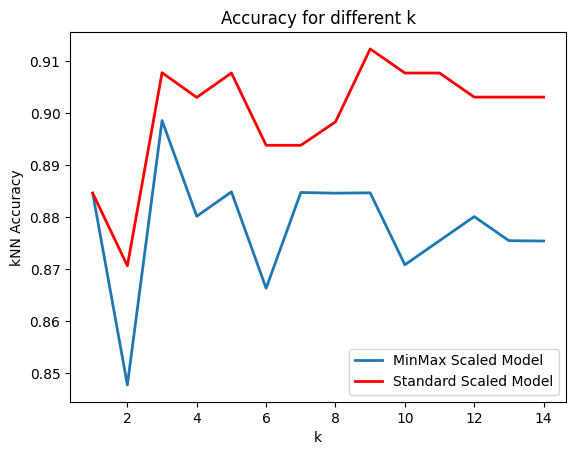

In [491]:
k_values = np.arange(1,15)
plt.plot(k_values, minmax_scaled_acc, linewidth=2, label='MinMax Scaled Model')  # First accuracy line
plt.plot(k_values, std_scaled_acc, linewidth=2, color='red', label='Standard Scaled Model')  # Second accuracy line

plt.xlabel('k')
plt.ylabel('kNN Accuracy')
plt.title('Accuracy for different k')
plt.legend()  
plt.show() 

Once we determine the best k, test the model on train

/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/2775888505.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df[pred] = minmax_scaling(scaled_df[pred])
/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/2775888505.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df[['date', 'response']] = df[['date', 'response']]
/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/2775888505.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of

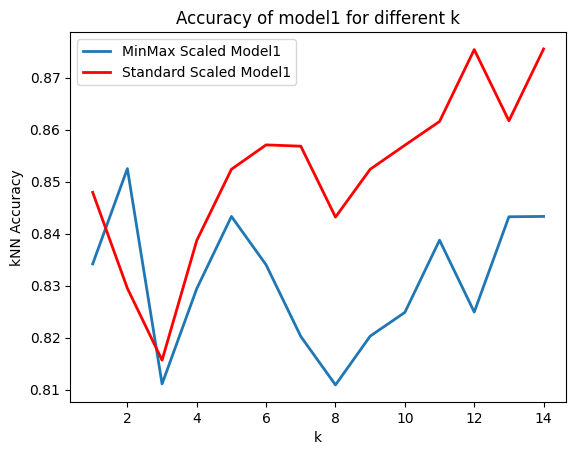

/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/2775888505.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df[pred] = minmax_scaling(scaled_df[pred])
/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/2775888505.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df[['date', 'response']] = df[['date', 'response']]
/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/2775888505.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of

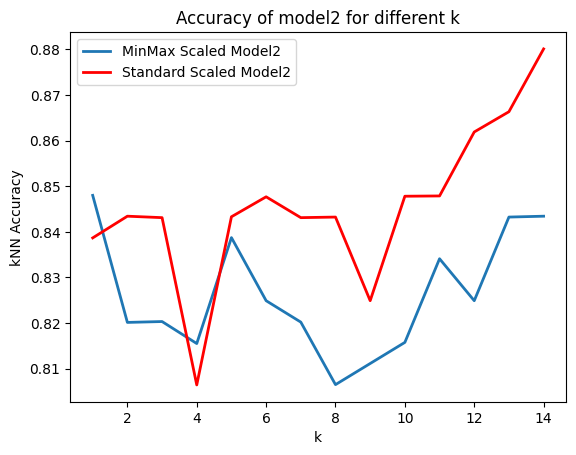

/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/2775888505.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df[pred] = minmax_scaling(scaled_df[pred])
/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/2775888505.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df[['date', 'response']] = df[['date', 'response']]
/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/2775888505.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of

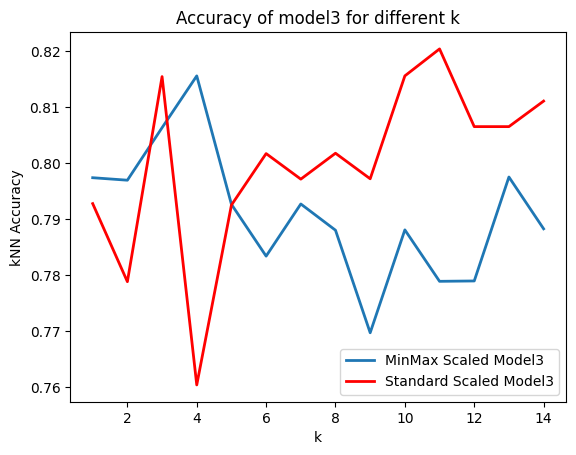

/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/2775888505.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df[pred] = minmax_scaling(scaled_df[pred])
/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/2775888505.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df[['date', 'response']] = df[['date', 'response']]
/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_1991/2775888505.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of

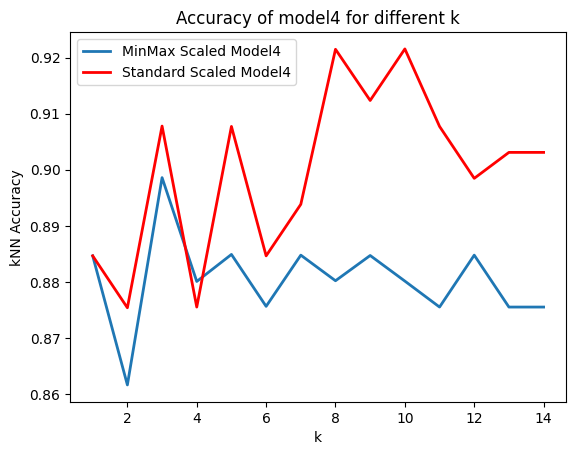

In [547]:
set_of_preds = [['1stWon', '2ndWon','SvGms', 'bpFaced'], ['rank', '1stWon', '2ndWon','SvGms', 'bpFaced'], ['rank', '1stWon','SvGms', 'bpFaced'], ['ace', '1stWon', '2ndWon','SvGms', 'bpFaced']]
k_values = np.arange(1,15)

for mod, predictors in enumerate(set_of_preds):
    minmax_scaled_acc = knn_accuracies(diff_df, predictors, 'minmax')
    std_scaled_acc = knn_accuracies(diff_df, predictors, ' ')
    plt.plot(k_values, minmax_scaled_acc, linewidth=2, label=f'MinMax Scaled Model{mod+1}')  # First accuracy line
    plt.plot(k_values, std_scaled_acc, linewidth=2, color='red', label=f'Standard Scaled Model{mod+1}')  # Second accuracy line
    plt.xlabel('k')
    plt.ylabel('kNN Accuracy')
    plt.title(f'Accuracy of model{mod+1} for different k')
    plt.legend()  
    plt.show() 
    

Clearly, StandardScalar is better than minmax for this kNN.

['ace', '1stWon', '2ndWon','SvGms', 'bpFaced'] is definitely the best predictors for kNN, with optimal k=9 or 10.

In [501]:
def knn_test_data(df, preds, k):
    '''  
    calculate knn accuracies for given predictors using standard scaling
    for given k on test data.
    Returns best k and the accuracy of this model on the test set
    '''
    scaled_df = df[preds]
    scaled_df = scale_preds(df, preds)
    scaled_df[['date', 'response']] = df[['date', 'response']]

    X_train_knn, X_test_knn, y_train_knn, y_test_knn = split_data(scaled_df, preds)  
    
    k_preds = classify(X_train_knn, y_train_knn, X_test_knn, k)['Predicted_Class'].apply(int)   
    acc = sum(y_test_knn == k_preds)/len(y_train_knn)    
    return (k, acc)

In [548]:
pred1 = ['ace', '1stWon', '2ndWon','SvGms', 'bpFaced']
for k in [8,9,10]:
    temp_k, temp_acc = knn_test_data(diff_df, pred1, k)
    print(f'model:\nk: {temp_k}, acc: {temp_acc}')

model:
k: 8, acc: 0.5483870967741935
model:
k: 9, acc: 0.5391705069124424
model:
k: 10, acc: 0.5391705069124424


In [ ]:
pred2 = ['rank', '1stWon', '2ndWon','SvGms', 'bpFaced']
ks2 = [3,8,9,13]
for k in ks2:
    temp_k, temp_acc = knn_test_data(diff_df, pred2, k)
    print(f'model:\nk: {temp_k}, acc: {temp_acc}')

model:
k: 3, acc: 0.543778801843318
model:
k: 8, acc: 0.543778801843318
model:
k: 9, acc: 0.543778801843318
model:
k: 13, acc: 0.5483870967741935
